In [1]:
!pip install transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [102]:
import torch
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, DataCollatorWithPadding

import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from torch import nn, optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 8, 6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
df = pd.read_csv('/content/drive/MyDrive/playstore/reviews.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
0,6e865ed7-6788-49cf-9810-0541068e3882,Gianna,https://play-lh.googleusercontent.com/a-/ALV-U...,The 'upgrade to premium' button is right in th...,1,2,5.18.0.2,2024-07-13 22:25:37,You can dismiss the premium option and keep us...,2024-07-14 08:30:22,5.18.0.2,most_relevant,com.anydo
1,ca11e275-f9a7-4b0a-a4d1-f2981b568a46,David Ottley,https://play-lh.googleusercontent.com/a/ACg8oc...,"I have used this app for several years, and it...",1,26,5.18.0.2,2024-06-08 18:42:11,Please contact our team and we will help you r...,2024-06-09 09:56:26,5.18.0.2,most_relevant,com.anydo
2,0197c118-5c6f-4a7b-894c-970023d1a350,Mar Zur,https://play-lh.googleusercontent.com/a/ACg8oc...,I have the same recurring tasks to do every da...,1,15,4.16.6.2,2020-07-22 13:13:10,Our team will be happy to look into it for you...,2020-07-23 16:32:02,4.16.6.2,most_relevant,com.anydo
3,94868fb5-a21d-4ef9-ab85-81b2ed3d0785,Devin Rivera,https://play-lh.googleusercontent.com/a-/ALV-U...,"Instead of shopping around, I downloaded Any.d...",1,11,NaN,2020-12-08 06:24:40,We are not aware of any issues with randomized...,2020-12-10 09:38:20,NaN,most_relevant,com.anydo
4,4be108fd-03e4-4698-b685-ad73ebefe3e9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"I was a big fan of this app, but the recent UI...",1,91,4.10.6.1,2018-11-18 14:31:49,This is very strange behavior for your reminde...,2018-11-19 17:13:30,4.10.6.1,most_relevant,com.anydo


In [5]:
df.shape

(17666, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17666 entries, 0 to 17665
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              17666 non-null  object
 1   userName              17666 non-null  object
 2   userImage             17666 non-null  object
 3   content               17665 non-null  object
 4   score                 17666 non-null  int64 
 5   thumbsUpCount         17666 non-null  int64 
 6   reviewCreatedVersion  15120 non-null  object
 7   at                    17666 non-null  object
 8   replyContent          9856 non-null   object
 9   repliedAt             9856 non-null   object
 10  appVersion            15120 non-null  object
 11  sortOrder             17666 non-null  object
 12  appId                 17666 non-null  object
dtypes: int64(2), object(11)
memory usage: 1.8+ MB


In [7]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

In [8]:
df["sentiment"] = df.score.apply(to_sentiment)

In [9]:
class_names = ['negative', 'neutral', 'positive']

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17666 entries, 0 to 17665
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              17666 non-null  object
 1   userName              17666 non-null  object
 2   userImage             17666 non-null  object
 3   content               17665 non-null  object
 4   score                 17666 non-null  int64 
 5   thumbsUpCount         17666 non-null  int64 
 6   reviewCreatedVersion  15120 non-null  object
 7   at                    17666 non-null  object
 8   replyContent          9856 non-null   object
 9   repliedAt             9856 non-null   object
 10  appVersion            15120 non-null  object
 11  sortOrder             17666 non-null  object
 12  appId                 17666 non-null  object
 13  sentiment             17666 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 1.9+ MB


In [11]:
df['sentiment'].value_counts()

sentiment
2    6000
0    5934
1    5732
Name: count, dtype: int64

### Data Pre-processing

In [12]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
sample_text = "When was I last outside, I am stuck at home for 2 weeks"

In [15]:
tokens = tokenizer.tokenize(sample_text)

In [16]:
tokens

['when',
 'was',
 'i',
 'last',
 'outside',
 ',',
 'i',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks']

In [17]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
token_ids

[2043,
 2001,
 1045,
 2197,
 2648,
 1010,
 1045,
 2572,
 5881,
 2012,
 2188,
 2005,
 1016,
 3134]

### Special Tokens

In [18]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [19]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [20]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [21]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [79]:
encoding = tokenizer(
    sample_text,
    max_length = 128,
    padding = 'max_length',
    truncation = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    return_attention_mask = True,
    return_tensors = 'pt'
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17665 entries, 0 to 17665
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              17665 non-null  object
 1   userName              17665 non-null  object
 2   userImage             17665 non-null  object
 3   content               17665 non-null  object
 4   score                 17665 non-null  int64 
 5   thumbsUpCount         17665 non-null  int64 
 6   reviewCreatedVersion  15119 non-null  object
 7   at                    17665 non-null  object
 8   replyContent          9855 non-null   object
 9   repliedAt             9855 non-null   object
 10  appVersion            15119 non-null  object
 11  sortOrder             17665 non-null  object
 12  appId                 17665 non-null  object
 13  sentiment             17665 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 2.0+ MB


In [54]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

<ipython-input-55-4dbe9bd8b56e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


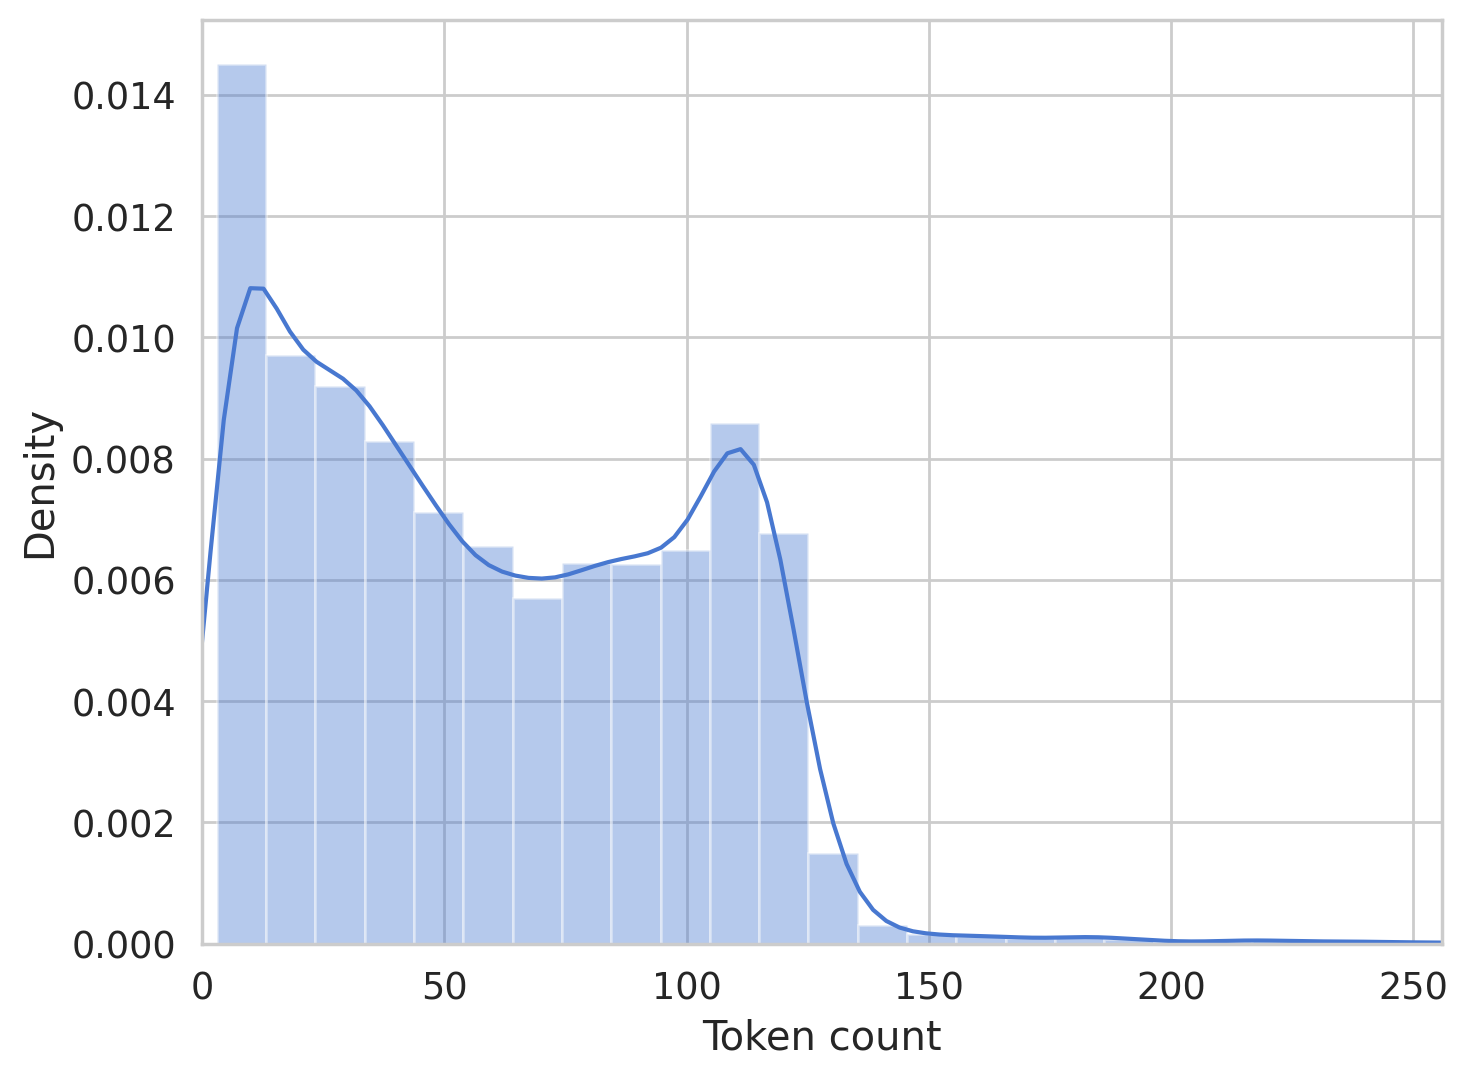

In [55]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

### Create Dataset

In [87]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer(
    review,
    max_length = 128,
    padding = 'max_length',
    truncation = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    return_attention_mask = True,
    return_tensors = 'pt'
)
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [88]:
MAX_LENGTH = 128
BATCH_SIZE = 8
EPOCHS = 20

In [89]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [90]:
df_train.shape, df_val.shape, df_test.shape

((15898, 14), (883, 14), (884, 14))

In [91]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
      reviews=df.content.to_numpy(),
      targets=df.sentiment.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
    )
  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )

In [103]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [104]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LENGTH, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LENGTH, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LENGTH, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [105]:
data = next(iter(train_data_loader))
data.keys()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [106]:
print(data['input_ids'].shape)

torch.Size([8, 128])


In [107]:
print(data['attention_mask'].shape)

torch.Size([8, 128])


In [108]:
print(data['targets'].shape)

torch.Size([8])


### Model

In [109]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [110]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [111]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [112]:
model = SentimentClassifier(len(class_names))
model = model.to(DEVICE)

In [113]:
input_ids = data['input_ids'].to(DEVICE)
attention_mask = data['attention_mask'].to(DEVICE)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 128])
torch.Size([8, 128])


In [114]:
with torch.no_grad():
  outputs = model(input_ids=input_ids, attention_mask=attention_mask)

last_hidden_state = outputs.last_hidden_state
logits = last_hidden_state.mean(dim=1)
softmax_output = torch.nn.functional.softmax(logits, dim=1)

# Print shapes to verify
print(f"Last hidden state shape: {last_hidden_state.shape}")
print(f"Logits shape: {logits.shape}")
print(f"Softmax output shape: {softmax_output.shape}")

TypeError: dropout(): argument 'input' (position 1) must be Tensor, not str